In [93]:
import pandas as pd
import tensorflow as tf
import numpy as np
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig

from scipy.special import softmax
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import requests

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from transformers import BertTokenizer, TFBertForSequenceClassification
from tqdm import tqdm
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import Input, Model

In [2]:
# Excel file
excel_file_path = "/home/narayana.mayya@sapt.local/projects/Antoine_coefficient_modelling/wysa/ML Assignment Dataset.xlsx"

# Read all sheets into a dictionary of DataFrames
dfs = pd.read_excel(excel_file_path, sheet_name=None)

#Sheet Names: ['Dataset Card', 'Train', 'Test']
df_train = dfs['Train']
df_test = dfs['Test']

In [3]:
print("Train shape:",df_train.shape)
print("Test shape:",df_test.shape)

Train shape: (8589, 3)
Test shape: (504, 1)


In [4]:
df_train.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')

In [5]:
df_train['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [7]:
df_train['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2672
Negative emotion                       519
I can't tell                             9
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8589 entries, 0 to 8588
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8588 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8589 non-null   object
dtypes: object(3)
memory usage: 201.4+ KB


In [23]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   504 non-null    object
dtypes: object(1)
memory usage: 4.1+ KB


In [9]:
# 'I can't tell' label has only 9 points. either drop it or find more points. dropping it here.
df_train_fil = df_train[~(df_train['is_there_an_emotion_directed_at_a_brand_or_product'] == "I can't tell")]

In [10]:
df_train_fil.shape

(8580, 3)

In [12]:
df_train_fil_sent = df_train_fil[['tweet_text','is_there_an_emotion_directed_at_a_brand_or_product']]

In [13]:
df_train_fil_sent_dropn = df_train_fil_sent.dropna()

In [14]:
# FINAL train count for sentiments
df_train_fil_sent_dropn.shape

(8579, 2)

### EDA

#Perform Exploratory Data Analysis (EDA) on the dataset and report your findings about any observations or patterns.
- some labelling is ambiguous. making it more accurate will improve the final test report.

#Take any liberty to augment the dataset and fine-tune a pre-trained transformer model to predict the emotion and/or the product the emotion is targeted towards,
- the pretrained model is already trained on large amount of data for sentiment analysis.


### Sentiment model

In [15]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [36]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#model.save_pretrained(MODEL)
#text = "Covid cases are increasing fast!"
pred_label = []
pred_scor = []
def predict_pret(text):
    #print(text)
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    l = config.id2label[ranking[0]]
    s = scores[ranking[0]]
    return l,s

for i,row in df_train_fil_sent_dropn.iterrows():
    l,s = predict_pret(row['tweet_text'])
    pred_label.append(l)
    pred_scor.append(s)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


'\nfor i in range(scores.shape[0]):\n    l = config.id2label[ranking[i]]\n    s = scores[ranking[i]]\n    print(f"{i+1}) {l} {np.round(float(s), 4)}")\n'

In [21]:
#SINGLE TEXT TEST for sentiments
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#model.save_pretrained(MODEL)
#text = "Covid cases are increasing fast!"
pred_label = []
pred_scor = []
def predict_pret(text):
    #print(text)
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    l = config.id2label[ranking[0]]
    s = scores[ranking[0]]
    return l,s

#for i,row in df_train_fil_sent_dropn.iterrows():
l,s = predict_pret('&quot;papyrus...sort of like the ipad&quot; - nice! Lol! #SXSW Lavelle')
pred_label.append(l)
pred_scor.append(s)    
'''
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")
'''


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


'\nfor i in range(scores.shape[0]):\n    l = config.id2label[ranking[i]]\n    s = scores[ranking[i]]\n    print(f"{i+1}) {l} {np.round(float(s), 4)}")\n'

In [63]:
#pred_label = pd.Series(pred_label).map({'Positive emotion':0,'Negative emotion':1,'No emotion toward brand or product':2})

In [8]:
#df_train_fil_sent_dropn = pd.read_csv("/home/narayana.mayya@sapt.local/projects/Antoine_coefficient_modelling/wysa/df_predicted.csv")

In [4]:
#df_train_fil_sent_dropn['is_there_an_emotion_directed_at_a_brand_or_product']=df_train_fil_sent_dropn['is_there_an_emotion_directed_at_a_brand_or_product'].map({'Positive emotion':'0','Negative emotion':'1','No emotion toward brand or product':'2'})
#df_train_fil_sent_dropn['predicted_label'] = df_train_fil_sent_dropn['predicted_label'].map({'Positive emotion':'0','Negative emotion':'1','No emotion toward brand or product':'2'})

In [41]:
df_train_fil_sent_dropn.shape

(8579, 3)

In [40]:
df_train_fil_sent_dropn['predicted_label'] = pred_label
#df_train_fil_sent_dropn.to_csv("/home/narayana.mayya@sapt.local/projects/Antoine_coefficient_modelling/wysa/df_predicted.csv")

/tmp/ipykernel_3554714/2741702983.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_fil_sent_dropn['predicted_label'] = pred_label


In [42]:
df_train_fil_sent_dropn_droppred = df_train_fil_sent_dropn.dropna()

In [49]:
df_train_fil_sent_dropn_droppred.shape

(8579, 3)

In [16]:
#df_train_fil_sent_dropn_droppred.to_csv("/home/narayana.mayya@sapt.local/projects/Antoine_coefficient_modelling/wysa/df_predicted_2ndt.csv",index=False)
df_train_fil_sent_dropn_droppred = pd.read_csv("/home/narayana.mayya@sapt.local/projects/Antoine_coefficient_modelling/wysa/df_predicted_2ndt.csv")

In [17]:
df_train_fil_sent_dropn_droppred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8579 entries, 0 to 8578
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8579 non-null   object
 1   is_there_an_emotion_directed_at_a_brand_or_product  8579 non-null   object
 2   predicted_label                                     8579 non-null   object
dtypes: object(3)
memory usage: 201.2+ KB


In [18]:
df_train_fil_sent_dropn_droppred['predicted_label'].unique()

array(['negative', 'positive', 'neutral'], dtype=object)

In [19]:
df_train_fil_sent_dropn_droppred['predicted_label'] = df_train_fil_sent_dropn_droppred['predicted_label'].map({'positive':'Positive emotion','negative':'Negative emotion','neutral':'No emotion toward brand or product'})

In [20]:
y_true = df_train_fil_sent_dropn_droppred['is_there_an_emotion_directed_at_a_brand_or_product']
y_pred = df_train_fil_sent_dropn_droppred['predicted_label']

# Calculate and print accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate and print precision, recall, and F1 score for each class
precision = precision_score(y_true, y_pred, labels=['Positive emotion','Negative emotion','No emotion toward brand or product'], average=None)
recall = recall_score(y_true, y_pred, labels=['Positive emotion','Negative emotion','No emotion toward brand or product'], average=None)
f1 = sklearn.metrics.f1_score(y_true, y_pred, labels=['Positive emotion','Negative emotion','No emotion toward brand or product'], average=None)

print('\nClass-wise Metrics:')
for class_label, prec, rec, f1_score in zip(['Positive emotion','Negative emotion','No emotion toward brand or product'], precision, recall, f1):
    print(f'Class {class_label}: Precision={prec:.2f}, Recall={rec:.2f}, F1 Score={f1_score:.2f}')

# Calculate and print overall precision, recall, and F1 score (micro-average)
micro_precision = precision_score(y_true, y_pred, labels=['Positive emotion','Negative emotion','No emotion toward brand or product'], average='micro')
micro_recall = recall_score(y_true, y_pred, labels=['Positive emotion','Negative emotion','No emotion toward brand or product'], average='micro')
micro_f1 = sklearn.metrics.f1_score(y_true, y_pred, labels=['Positive emotion','Negative emotion','No emotion toward brand or product'], average='micro')

print('\nMicro-average Metrics:')
print(f'Micro-average Precision={micro_precision:.2f}, Recall={micro_recall:.2f}, F1 Score={micro_f1:.2f}')

# Print classification report
print('\nClassification Report:')
print(classification_report(y_true, y_pred))

Accuracy: 0.67

Class-wise Metrics:
Class Positive emotion: Precision=0.55, Recall=0.69, F1 Score=0.61
Class Negative emotion: Precision=0.39, Recall=0.56, F1 Score=0.46
Class No emotion toward brand or product: Precision=0.81, Recall=0.68, F1 Score=0.74

Micro-average Metrics:
Micro-average Precision=0.67, Recall=0.67, F1 Score=0.67

Classification Report:
                                    precision    recall  f1-score   support

                  Negative emotion       0.39      0.56      0.46       519
No emotion toward brand or product       0.81      0.68      0.74      5388
                  Positive emotion       0.55      0.69      0.61      2672

                          accuracy                           0.67      8579
                         macro avg       0.58      0.64      0.60      8579
                      weighted avg       0.70      0.67      0.68      8579



In [21]:
df_train_fil_sent_dropn_droppred['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2672
Negative emotion                       519
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

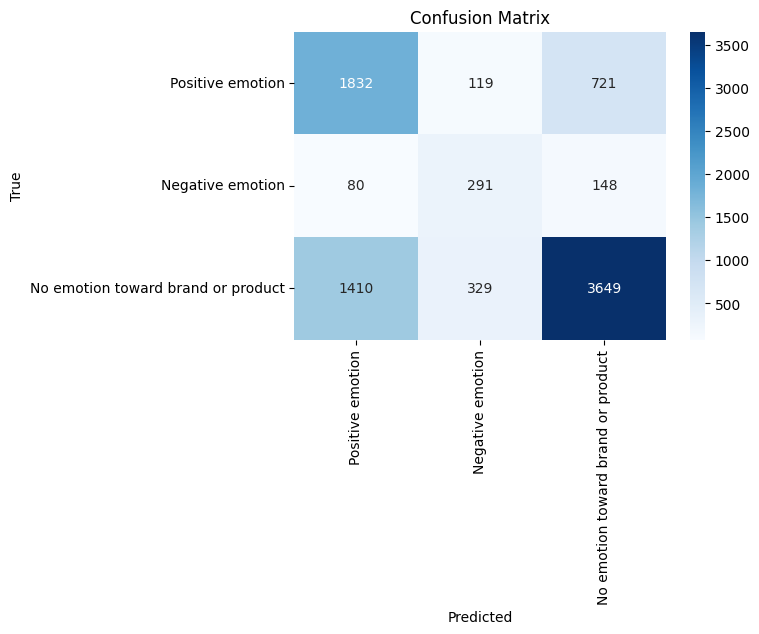

In [22]:
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred,labels=['Positive emotion','Negative emotion','No emotion toward brand or product'])

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive emotion','Negative emotion','No emotion toward brand or product'], yticklabels=['Positive emotion','Negative emotion','No emotion toward brand or product'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Test prediction

In [25]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#model.save_pretrained(MODEL)
#text = "Covid cases are increasing fast!"
pred_label = []
pred_scor = []
def predict_pret(text):
    #print(text)
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    l = config.id2label[ranking[0]]
    s = scores[ranking[0]]
    return l,s

for i,row in df_test.iterrows():
    l,s = predict_pret(row['Tweet'])
    pred_label.append(l)
    pred_scor.append(s)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
df_test['predicted_label'] = pred_label

In [27]:
#df_test.to_csv("/home/narayana.mayya@sapt.local/projects/Antoine_coefficient_modelling/wysa/test_result_sentiment.csv",index=False)

### targeted object prediction

In [81]:
df_train_fil_device = df_train[['tweet_text','emotion_in_tweet_is_directed_at']]

In [82]:
df_train_fil_device_dropn = df_train_fil_device.dropna()

In [83]:
df_train_fil_device_dropn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3291 entries, 0 to 8584
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   tweet_text                       3291 non-null   object
 1   emotion_in_tweet_is_directed_at  3291 non-null   object
dtypes: object(2)
memory usage: 77.1+ KB


In [84]:
df_train_fil_device_dropn['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [32]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(df_train_fil_device_dropn['emotion_in_tweet_is_directed_at']), y=df_train_fil_device_dropn['emotion_in_tweet_is_directed_at'])
class_weight = dict(enumerate(class_weights))

# Use class_weight parameter in model.fit
#finetuned_model.fit(train_dataset, validation_data=val_dataset, epochs=3, class_weight=class_weight)

In [33]:
class_weights

array([ 4.68803419,  4.51440329,  0.55320222,  0.8503876 , 10.44761905,
        1.2480091 ,  0.38653982,  0.77801418,  1.2312009 ])

In [85]:
df_train_fil_device_dropn['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [ ]:
df_train_fil_device_dropn['emotion_in_tweet_is_directed_at']

In [87]:
label_encoder.classes_

array(['Android', 'Android App', 'Apple', 'Google',
       'Other Apple product or service',
       'Other Google product or service', 'iPad', 'iPad or iPhone App',
       'iPhone'], dtype=object)

In [86]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#os.environ["CUDA_VISIBLE_DEVICES"] = "2"
#with tf.device('/device:GPU:2'):
# Use LabelEncoder to convert categorical labels to numerical labels
label_encoder = LabelEncoder()
df_train_fil_device_dropn['emotion_in_tweet_is_directed_at'] = label_encoder.fit_transform(df_train_fil_device_dropn['emotion_in_tweet_is_directed_at'])

# Use OneHotEncoder to one-hot encode the numerical labels
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
encoded_labels = onehot_encoder.fit_transform(df_train_fil_device_dropn[['emotion_in_tweet_is_directed_at']])

# Create a new DataFrame with one-hot encoded labels
encoded_df = pd.DataFrame(encoded_labels, columns=[f'emotion_{i}' for i in range(encoded_labels.shape[1])])

/tmp/ipykernel_243403/420772195.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_fil_device_dropn['emotion_in_tweet_is_directed_at'] = label_encoder.fit_transform(df_train_fil_device_dropn['emotion_in_tweet_is_directed_at'])
/home/narayana.mayya@sapt.local/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [40]:
df_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5250 entries, 0 to 3288
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   tweet_text                       3291 non-null   object 
 1   emotion_in_tweet_is_directed_at  3291 non-null   float64
 2   emotion_0                        3291 non-null   float64
 3   emotion_1                        3291 non-null   float64
 4   emotion_2                        3291 non-null   float64
 5   emotion_3                        3291 non-null   float64
 6   emotion_4                        3291 non-null   float64
 7   emotion_5                        3291 non-null   float64
 8   emotion_6                        3291 non-null   float64
 9   emotion_7                        3291 non-null   float64
 10  emotion_8                        3291 non-null   float64
dtypes: float64(10), object(1)
memory usage: 492.2+ KB


In [53]:
encoded_df

,emotion_0,emotion_1,emotion_2,emotion_3,emotion_4,emotion_5,emotion_6,emotion_7,emotion_8
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3287,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3288,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [88]:
df_train_fil_device_dropn = df_train_fil_device_dropn.reset_index(drop=True)

In [94]:
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy


# Concatenate the new DataFrame with the original DataFrame
df_train_encoded = pd.concat([df_train_fil_device_dropn, encoded_df], axis=1)

# Drop the original categorical label column
df_train_encoded.drop('emotion_in_tweet_is_directed_at', axis=1, inplace=True)

# Split the dataset into training and validation sets
stratify_columns = ['emotion_0', 'emotion_1', 'emotion_2','emotion_3', 'emotion_4', 'emotion_5','emotion_6', 'emotion_7', 'emotion_8'] 
train_df, val_df = train_test_split(df_train_encoded, test_size=0.1, random_state=42, stratify=df_train_encoded[stratify_columns])

# Load pre-trained BERT model and tokenizer
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=9)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode the training and validation datasets
def tokenize_dataset(df):
    return tokenizer(df['tweet_text'].tolist(), padding=True, truncation=True, return_tensors='tf')

train_encodings = tokenize_dataset(train_df)
val_encodings = tokenize_dataset(val_df)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_df.iloc[:, -9:].astype('float32')))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_df.iloc[:, -9:].astype('float32')))

# Prepare the datasets
train_dataset = train_dataset.shuffle(len(train_df)).batch(8)
val_dataset = val_dataset.batch(8)

# Set up the model
input_ids = Input(shape=(None,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(None,), dtype=tf.int32, name="attention_mask")
outputs = model([input_ids, attention_mask])

# Define and compile the model
finetuned_model = Model(inputs=[input_ids, attention_mask], outputs=outputs.logits)
optimizer = Adam(learning_rate=2e-5)
finetuned_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Train the model
#finetuned_model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# Save the fine-tuned model
#finetuned_model.save('fine_tuned_bert_model_new')

# Set up callbacks
checkpoint_path = 'best_model_checkpoint_val_acc_{val_accuracy:.4f}_epoch_{epoch:02d}.h5'
model_checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with callbacks
history = finetuned_model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=10, 
    callbacks=[model_checkpoint, early_stopping]
)

# Save the final model using Pickle
with open('fine_tuned_bert_model_new.pkl', 'wb') as f:
    pickle.dump(finetuned_model, f)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10


2023-12-17 12:58:41.446494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [2961,61]
	 [[{{node Placeholder/_2}}]]
2023-12-17 12:58:41.446820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [2961,61]
	 [[{{node Placeholder/_1}}]]
/home/narayana.mayya@sapt.local/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


371/371 [==============================] - ETA: 0s - loss: 1.0567 - accuracy: 0.6369

2023-12-17 13:00:11.244508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [330,9]
	 [[{{node Placeholder/_3}}]]


371/371 [==============================] - 97s 158ms/step - loss: 1.0567 - accuracy: 0.6369 - val_loss: 0.5245 - val_accuracy: 0.8030
Epoch 2/10
371/371 [==============================] - 53s 142ms/step - loss: 0.4082 - accuracy: 0.8632 - val_loss: 0.4424 - val_accuracy: 0.8364
Epoch 3/10
371/371 [==============================] - 51s 137ms/step - loss: 0.2630 - accuracy: 0.9179 - val_loss: 0.4106 - val_accuracy: 0.8697
Epoch 4/10
371/371 [==============================] - 48s 129ms/step - loss: 0.2014 - accuracy: 0.9389 - val_loss: 0.4804 - val_accuracy: 0.8727
Epoch 5/10
371/371 [==============================] - 48s 129ms/step - loss: 0.1345 - accuracy: 0.9618 - val_loss: 0.4835 - val_accuracy: 0.8667
Epoch 6/10
371/371 [==============================] - 48s 129ms/step - loss: 0.0996 - accuracy: 0.9693 - val_loss: 0.5162 - val_accuracy: 0.8788


/home/narayana.mayya@sapt.local/anaconda3/envs/tf/lib/python3.9/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [96]:
from tensorflow.keras.models import load_model
from transformers import TFBertForSequenceClassification

# Define the custom objects (custom layers) needed for loading the model
custom_objects = {"TFBertForSequenceClassification": TFBertForSequenceClassification}

# Load the best model checkpoint
best_model = load_model('/home/narayana.mayya@sapt.local/projects/Antoine_coefficient_modelling/wysa/best_model_checkpoint_val_acc_0.8697_epoch_03.h5', custom_objects=custom_objects)

# Assuming you already have the test set DataFrame (df_test) and tokenizer
test_encodings = tokenizer(df_test['Tweet'].tolist(), padding=True, truncation=True, return_tensors='tf')
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings)))

# Make predictions on the test set using the loaded model
predictions_probabilities = best_model.predict(test_dataset.batch(8))

# Convert probabilities to one-hot encoded predictions
predictions_onehot = np.eye(9)[np.argmax(predictions_probabilities, axis=1)]

# Display or save the DataFrame with predicted labels
df_test['predicted_labels_items'] = np.argmax(predictions_probabilities, axis=1)
df_test['predicted_labels_items'] = label_encoder.inverse_transform(df_test['predicted_labels_items'])

# Display or save the DataFrame with predicted labels
print(df_test[['Tweet', 'predicted_labels_items']])


2023-12-17 13:22:27.021215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [504,55]
	 [[{{node Placeholder/_2}}]]


63/63 [==============================] - 5s 44ms/step
                                                 Tweet predicted_labels_items
0    Hand-Held ���Hobo�۪: Drafthouse launches ���Ho...     iPad or iPhone App
1    Again? RT @mention Line at the Apple store is ...                  Apple
2    Boooo! RT @mention Flipboard is developing an ...                 iPhone
3    Thanks to @mention for publishing the news of ...     iPad or iPhone App
4    ���@mention &quot;Apple has opened a pop-up st...                  Apple
..                                                 ...                    ...
499  Hey is anyone doing #sxsw signing up for the g...     iPad or iPhone App
500  @mention you can buy my used iPad and I'll pic...                   iPad
501  @mention You could buy a new iPad 2 tmrw at th...                   iPad
502  Guys, if you ever plan on attending #SXSW, you...                   iPad
503  &quot;Do you know what Apple is really good at...                  Apple

[504 rows

In [99]:
import joblib
# Save the LabelEncoder to a file
joblib.dump(label_encoder, 'label_encoder.joblib')

['label_encoder.joblib']

In [97]:
#df_test.to_csv("/home/narayana.mayya@sapt.local/projects/Antoine_coefficient_modelling/wysa/delete_later.csv")

In [89]:
# Load the fine-tuned BERT model
#model = tf.keras.models.load_model('fine_tuned_bert_model')
model = finetuned_model

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode the test set
test_encodings = tokenizer(df_test['Tweet'].tolist(), padding=True, truncation=True, return_tensors='tf')

# Prepare the dataset
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings)))

# Make predictions on the test set
predictions_probabilities = model.predict(test_dataset.batch(8))


# Convert probabilities to one-hot encoded predictions
predictions_onehot = np.eye(9)[np.argmax(predictions_probabilities, axis=1)]

# Display or save the DataFrame with predicted labels
df_test['predicted_labels_items'] = np.argmax(predictions_probabilities, axis=1)
df_test['predicted_labels_items'] = label_encoder.inverse_transform(df_test['predicted_labels_items'])

# Display or save the DataFrame with predicted labels
print(df_test[['Tweet', 'predicted_labels_items']])

2023-12-17 12:10:01.966996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [504,55]
	 [[{{node Placeholder/_2}}]]
/home/narayana.mayya@sapt.local/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


63/63 [==============================] - 5s 46ms/step
                                                 Tweet predicted_labels_items
0    Hand-Held ���Hobo�۪: Drafthouse launches ���Ho...     iPad or iPhone App
1    Again? RT @mention Line at the Apple store is ...                  Apple
2    Boooo! RT @mention Flipboard is developing an ...                 iPhone
3    Thanks to @mention for publishing the news of ...     iPad or iPhone App
4    ���@mention &quot;Apple has opened a pop-up st...                   iPad
..                                                 ...                    ...
499  Hey is anyone doing #sxsw signing up for the g...     iPad or iPhone App
500  @mention you can buy my used iPad and I'll pic...                   iPad
501  @mention You could buy a new iPad 2 tmrw at th...                   iPad
502  Guys, if you ever plan on attending #SXSW, you...                   iPad
503  &quot;Do you know what Apple is really good at...                  Apple

[504 rows

In [91]:
#df_test.to_csv("/home/narayana.mayya@sapt.local/projects/Antoine_coefficient_modelling/wysa/test_result_sentiment+device.csv",index=False)

In [3]:
#!pip install --upgrade jupyter jupyterlab notebook

#Explain your approach to evaluate the trained model.
    - for sentiment classification - accuracy (0.67), precision, recall, micro f1 score (0.67)
    - for item classification - accuracy , precision, recall, f1 score

In [61]:
#!pip install --upgrade requests

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


#Propose ways to improve the dataset further.
- manual labelling has to be improved.
- Item classification will require lot more data as there can be large number of items.